**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 2


En el ejercicio 2 de la parte 1 del entregable seleccionaron las filas y columnas relevantes al problema de predicción de precios de una propiedad e imputaron los valores faltantes de las columnas `Suburb` y las columnas obtenidas a partir del conjunto de datos `airbnb`.

En esta notebook, **se utilizará resultado de dichas operaciones.** que fue guardado en un archivo (Ejercicio 3 entregable 1). 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix

import seaborn as sns
sns.set_context('talk')

In [2]:
# Acá deberían leer el conjunto de datos que ya tienen.
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')
melb_df[:3]

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas. 
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


### **1. Cargamos la base de datos con la que vamos a trabajar** 
Cargamos el archivo .csv final de la primer parte del entregable de la materia "Exploración y curación de datos" y lo filtramos dejando todas las columnas menos "YearBuilt". La columna "Building Area" no fue tomada en cuenta para el archivo final dada la poca cantidad de datos disponibles y teniendo en cuenta que esta la variable "Landsize" como sustituto próximo, que además contaba con más datos que la primera.

In [3]:
from google.colab import files 
  
files.upload()

Saving df_melb_final.csv to df_melb_final.csv


{'df_melb_final.csv': b'Suburb,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,YearBuilt,Lattitude,Longtitude,Property Type,Rent Price mean,Rent Price min,Rent Price count,Review Scores Rating median\nMelbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,0.0,2004.0,-37.8106,144.9646,Apartment,145.9481116584565,19,3045,95.0\nMelbourne,2.0,520000.0,2.8,3000.0,1.0,1.0,1.0,4051.0,2005.0,-37.8072,144.9623,Apartment,145.9481116584565,19,3045,95.0\nMelbourne,3.0,760000.0,2.8,3000.0,2.0,2.0,1.0,0.0,1997.0,-37.8095,144.9691,Apartment,145.9481116584565,19,3045,95.0\nMelbourne,2.0,360000.0,2.8,3000.0,1.0,1.0,1.0,1136.0,2009.0,-37.8211,144.9559,Apartment,145.9481116584565,19,3045,95.0\nMelbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,0.0,2004.0,-37.8106,144.9646,Condominium,134.44444444444446,25,108,96.0\nMelbourne,2.0,520000.0,2.8,3000.0,1.0,1.0,1.0,4051.0,2005.0,-37.8072,144.9623,Condominium,134.44444444444446,25,108,96.0\nMelbourne,3.0,760000.0,2.8,3000.0,2.0,2.0,1.0,0.0,1997.0,-37.8095,144.9

In [4]:
melb_df_final = pd.read_csv('df_melb_final.csv') 

In [5]:
# Excluimos la columna YearBuilt y Landsize que también tiene valores nulos, para tener una matriz codificada sin Nan. 
melb_df_1 = melb_df_final.loc[:, ~melb_df_final.columns.isin(['YearBuilt', 'Landsize'])]
melb_df_1

,Suburb,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Property Type,Rent Price mean,Rent Price min,Rent Price count,Review Scores Rating median
0,Melbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,Apartment,145.948112,19,3045,95.0
1,Melbourne,2.0,520000.0,2.8,3000.0,1.0,1.0,1.0,-37.8072,144.9623,Apartment,145.948112,19,3045,95.0
2,Melbourne,3.0,760000.0,2.8,3000.0,2.0,2.0,1.0,-37.8095,144.9691,Apartment,145.948112,19,3045,95.0
3,Melbourne,2.0,360000.0,2.8,3000.0,1.0,1.0,1.0,-37.8211,144.9559,Apartment,145.948112,19,3045,95.0
4,Melbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,Condominium,134.444444,25,108,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Port Melbourne,3.0,1916000.0,3.8,3207.0,2.0,2.0,1.0,-37.8393,144.9470,Apartment,175.206107,40,131,97.0
137,Port Melbourne,2.0,1130000.0,3.8,3207.0,1.0,1.0,0.0,-37.8404,144.9422,Apartment,175.206107,40,131,97.0
138,Port Melbourne,3.0,1305000.0,3.8,3207.0,2.0,2.0,2.0,-37.8369,144.9183,Apartment,175.206107,40,131,97.0
139,Port Melbourne,2.0,520000.0,3.8,3207.0,1.0,1.0,1.0,-37.8407,144.9389,Apartment,175.206107,40,131,97.0


In [6]:
# Vamos a tomar las categorías más fecuentes de la variable Suburb
melb_df_1.Suburb.value_counts()

Northcote          26
Prahran            14
Richmond           14
Brunswick          14
Melbourne          12
Carlton            10
Fitzroy North       8
Seddon              7
Port Melbourne      5
Footscray           4
South Yarra         4
North Melbourne     3
Hawthorn            3
Fitzroy             2
Abbotsford          2
East Melbourne      2
Cremorne            2
Box Hill            2
West Melbourne      2
Elwood              2
Collingwood         1
St Kilda            1
Balaclava           1
Name: Suburb, dtype: int64

In [7]:
frec = ['Northcote', 'Prahran', 'Richmond', 'Brunswick', 'Melbourne','Carlton', 'Fitzroy North', 'Seddon', 'Port Melbourne']
melb_df_2 = melb_df_1[melb_df_1['Suburb'].isin(frec)].reset_index(drop = True)
melb_df_2

,Suburb,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Property Type,Rent Price mean,Rent Price min,Rent Price count,Review Scores Rating median
0,Melbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,Apartment,145.948112,19,3045,95.0
1,Melbourne,2.0,520000.0,2.8,3000.0,1.0,1.0,1.0,-37.8072,144.9623,Apartment,145.948112,19,3045,95.0
2,Melbourne,3.0,760000.0,2.8,3000.0,2.0,2.0,1.0,-37.8095,144.9691,Apartment,145.948112,19,3045,95.0
3,Melbourne,2.0,360000.0,2.8,3000.0,1.0,1.0,1.0,-37.8211,144.9559,Apartment,145.948112,19,3045,95.0
4,Melbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,Condominium,134.444444,25,108,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Port Melbourne,3.0,1916000.0,3.8,3207.0,2.0,2.0,1.0,-37.8393,144.9470,Apartment,175.206107,40,131,97.0
106,Port Melbourne,2.0,1130000.0,3.8,3207.0,1.0,1.0,0.0,-37.8404,144.9422,Apartment,175.206107,40,131,97.0
107,Port Melbourne,3.0,1305000.0,3.8,3207.0,2.0,2.0,2.0,-37.8369,144.9183,Apartment,175.206107,40,131,97.0
108,Port Melbourne,2.0,520000.0,3.8,3207.0,1.0,1.0,1.0,-37.8407,144.9389,Apartment,175.206107,40,131,97.0


### 2. **One hot-encoding**
Se va a realizar con las dos formas propuestas para ver que coincidan y corroborar que se realizo bien el one hot encoding.

In [8]:
var_num = ['Rooms','Price','Distance','Postcode','Bedroom2','Bathroom','Car','Lattitude','Longtitude','Rent Price mean','Rent Price min', 'Rent Price count', 'Review Scores Rating median']
var = ['Suburb','Property Type']

In [9]:
# Vemos la cantidad de categorías que tienen la variables Suburb y property type 
melb_df_2[var].nunique()

Suburb           9
Property Type    4
dtype: int64

In [10]:
# En las variables numéricas vemos la cantidad de números únicos (es decir, que no se repiten)
melb_df_2[var_num].nunique()

Rooms                           4
Price                          56
Distance                        9
Postcode                        9
Bedroom2                        4
Bathroom                        4
Car                             5
Lattitude                      54
Longtitude                     55
Rent Price mean                17
Rent Price min                  7
Rent Price count               15
Review Scores Rating median     6
dtype: int64

In [11]:
# Vemos si hay algún valor nulo en alguna de todas las variables
melb_df_2[var].isna().sum()

Suburb           0
Property Type    0
dtype: int64

In [12]:
melb_df_2[var_num].isna().sum()

Rooms                          0
Price                          0
Distance                       0
Postcode                       0
Bedroom2                       0
Bathroom                       0
Car                            0
Lattitude                      0
Longtitude                     0
Rent Price mean                0
Rent Price min                 0
Rent Price count               0
Review Scores Rating median    0
dtype: int64

OneHotEncoding y DictVectorizer, son dos formas de codificar variables categóricas donde en el segundo caso lo realiza de forma conjunta con las numéricas, es decir, toma todos los datos y nos devuelve la matriz con las columnas de las variables categóricas codificadas junto con las columnas con los valores de las numéricas. Ambas son dos formas de hacer lo mismo, en este caso se va a optar por utilizar OneHotEncoding. 

Todo este proceso aumenta la cantidad de memoria requerida para almacenar una varibale de manera cuadrática con respecto al número de matrices. La variable **suburb** tiene 23 categorías pero solo vamos a tomar 9, mientras que **property type** tiene 4 categorías, por ello se agregan 11 columnas más al dataframe melb_df_2. Sin embargo, los elementos de estas nuevas columnas son en su mayoría nulos y por ello sería conveniente trabajar con _matrices esparsas_, las cuales almacenan unicamente valores no-nulos de una matriz en distintas estructuras de datos. Este tipo de matrices son las que nos provee el OneHotEncoding y DictVectorizer. En caso de ser una matriz muy grande es mejor convertirlas en matrices densas y reducir su peso, este no sería el caso. 



In [13]:
# Variables categóricas 
sub = melb_df_2['Suburb'].unique().tolist()
prop_type = melb_df_2['Property Type'].unique().tolist()
enc = OneHotEncoder(categories = [sub, prop_type])
cat = enc.fit_transform(melb_df_2[['Suburb', 'Property Type']]).toarray()
cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
# El one hot encoding se utiliza para variables categóricas y no numéricas, las numéricas se van a transformar en vectores y se van a concatenar con las categóricas a través de numpy.hstack
var_num = ['Rooms','Price','Distance','Postcode','Bedroom2','Bathroom','Car','Lattitude','Longtitude','Rent Price mean','Rent Price min', 'Rent Price count', 'Review Scores Rating median']
num = melb_df_2[var_num].to_numpy()
num

array([[2.000e+00, 4.830e+05, 2.800e+00, ..., 1.900e+01, 3.045e+03,
        9.500e+01],
       [2.000e+00, 5.200e+05, 2.800e+00, ..., 1.900e+01, 3.045e+03,
        9.500e+01],
       [3.000e+00, 7.600e+05, 2.800e+00, ..., 1.900e+01, 3.045e+03,
        9.500e+01],
       ...,
       [3.000e+00, 1.305e+06, 3.800e+00, ..., 4.000e+01, 1.310e+02,
        9.700e+01],
       [2.000e+00, 5.200e+05, 3.800e+00, ..., 4.000e+01, 1.310e+02,
        9.700e+01],
       [4.000e+00, 2.160e+06, 3.800e+00, ..., 4.000e+01, 1.310e+02,
        9.700e+01]])

In [15]:
#Para concatenar la codificación de las variables categóricas y las numéricas necesito que sean arrays. Luego de concatenar se convierte en una matriz esparsa.
matrix = csr_matrix(np.hstack((num, cat)))
matrix

<110x26 sparse matrix of type '<class 'numpy.float64'>'
	with 1642 stored elements in Compressed Sparse Row format>

In [16]:
matrix.shape

(110, 26)

## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

## 1- Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.

Para agregar las variables 'BuildingArea' y 'YearBuilt' a la matriz del punto 1 primero se deben agregar estas columnas al dataframe melb_df_final y luego agregar dichas variables a la matriz.

In [17]:
# Como el dataframe obtenido en la primer parte del entregable no tiene la columna 'BuildingArea' primero se va a combinar nuestro archivo
# con la base de datos original, agregando dicha columna tomando la Latitud y la Longitud para más exactitud. 
df = melb_df[['Lattitude','Longtitude','BuildingArea', 'YearBuilt', 'Landsize']]
melb_df_aux = melb_df_2.merge(df, on = ['Lattitude','Longtitude'], how = 'left')
# Al combinar los dataframes se noto que habian filas con los mismo valores en todas las columnas excepto en BuildingArea, Landsuze y YearBuilt, esto se considera como erróneo dado que debería 
# existir solo un registro de BuildingArea para cada par de valores de Lattitude y Longitud, puede ser una falla de la función merge dado que las variables que se agrega tiene datos Nan, 
#y por ello se realiza un dropduplicates en ese subconjunto. De esta forma el dataframe queda conformado de 110 filas, al igual que el dataframe que se obtuvo en la parte 1. 
melb_df_aux = melb_df_aux.drop_duplicates(subset = ['Suburb','Rooms','Price','Distance','Postcode','Bedroom2','Bathroom','Car','Lattitude','Longtitude','Property Type','Rent Price mean','Rent Price min', 'Rent Price count', 'Review Scores Rating median']).reset_index(drop=True)
melb_df_aux['Landsize'] = melb_df_aux['Landsize'].replace(0, np.nan)#Cambiamos los valores ceros a nan para poder imputarle datos más adelante
melb_df_aux

,Suburb,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Property Type,Rent Price mean,Rent Price min,Rent Price count,Review Scores Rating median,BuildingArea,YearBuilt,Landsize
0,Melbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,Apartment,145.948112,19,3045,95.0,80.0,2004.0,NaN
1,Melbourne,2.0,520000.0,2.8,3000.0,1.0,1.0,1.0,-37.8072,144.9623,Apartment,145.948112,19,3045,95.0,68.0,2005.0,4051.0
2,Melbourne,3.0,760000.0,2.8,3000.0,2.0,2.0,1.0,-37.8095,144.9691,Apartment,145.948112,19,3045,95.0,85.0,1997.0,NaN
3,Melbourne,2.0,360000.0,2.8,3000.0,1.0,1.0,1.0,-37.8211,144.9559,Apartment,145.948112,19,3045,95.0,69.0,2009.0,1136.0
4,Melbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,Condominium,134.444444,25,108,96.0,80.0,2004.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Port Melbourne,3.0,1916000.0,3.8,3207.0,2.0,2.0,1.0,-37.8393,144.9470,Apartment,175.206107,40,131,97.0,NaN,1900.0,190.0
106,Port Melbourne,2.0,1130000.0,3.8,3207.0,1.0,1.0,0.0,-37.8404,144.9422,Apartment,175.206107,40,131,97.0,NaN,NaN,112.0
107,Port Melbourne,3.0,1305000.0,3.8,3207.0,2.0,2.0,2.0,-37.8369,144.9183,Apartment,175.206107,40,131,97.0,NaN,NaN,303.0
108,Port Melbourne,2.0,520000.0,3.8,3207.0,1.0,1.0,1.0,-37.8407,144.9389,Apartment,175.206107,40,131,97.0,70.0,2004.0,NaN


In [18]:
#Agregamos las columnas a la matriz 
var = melb_df_aux[['BuildingArea', 'YearBuilt', 'Landsize']]
# Vamos a utilizar la matriz codificada que contiene todas las variables para obtener una imputación más precisa
all_matrix = np.hstack((var, matrix.toarray()))
csr_matrix(all_matrix)

<110x29 sparse matrix of type '<class 'numpy.float64'>'
	with 1972 stored elements in Compressed Sparse Row format>

In [19]:
all_matrix.shape #Se agregan dos columnas más a la matriz

(110, 29)

## 2- Aplicación de una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables.

In [20]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer

melb_data_mice = melb_df_aux.copy(deep=True)

mice_imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor())

In [21]:
# Primero realizamos la imputación con los datos de las dos variables a imputar
melb_data_mice[['YearBuilt','BuildingArea']] = mice_imputer.fit_transform(melb_data_mice[['YearBuilt', 'BuildingArea']])
melb_data_mice[:20]

,Suburb,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Property Type,Rent Price mean,Rent Price min,Rent Price count,Review Scores Rating median,BuildingArea,YearBuilt,Landsize
0,Melbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,Apartment,145.948112,19,3045,95.0,80.0,2004.0,NaN
1,Melbourne,2.0,520000.0,2.8,3000.0,1.0,1.0,1.0,-37.8072,144.9623,Apartment,145.948112,19,3045,95.0,68.0,2005.0,4051.0
2,Melbourne,3.0,760000.0,2.8,3000.0,2.0,2.0,1.0,-37.8095,144.9691,Apartment,145.948112,19,3045,95.0,85.0,1997.0,NaN
3,Melbourne,2.0,360000.0,2.8,3000.0,1.0,1.0,1.0,-37.8211,144.9559,Apartment,145.948112,19,3045,95.0,69.0,2009.0,1136.0
4,Melbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,Condominium,134.444444,25,108,96.0,80.0,2004.0,NaN
5,Melbourne,2.0,520000.0,2.8,3000.0,1.0,1.0,1.0,-37.8072,144.9623,Condominium,134.444444,25,108,96.0,68.0,2005.0,4051.0
6,Melbourne,3.0,760000.0,2.8,3000.0,2.0,2.0,1.0,-37.8095,144.9691,Condominium,134.444444,25,108,96.0,85.0,1997.0,NaN
7,Melbourne,2.0,360000.0,2.8,3000.0,1.0,1.0,1.0,-37.8211,144.9559,Condominium,134.444444,25,108,96.0,69.0,2009.0,1136.0
8,Melbourne,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,Serviced apartment,232.176923,40,130,95.0,80.0,2004.0,NaN
9,Melbourne,2.0,520000.0,2.8,3000.0,1.0,1.0,1.0,-37.8072,144.9623,Serviced apartment,232.176923,40,130,95.0,68.0,2005.0,4051.0


## Estandarización 
Si bien la imputación debería mejorar cuando se tiene en cuenta todas las variables del dataframe, a través de la matriz codificada, los datos de las variables no tienen una relación directa con los valores de las varibales a imputar. Por lo tanto se va a proceder a estandarizar los datos de las variables numéricas, a cada valor que asume la variable se lo resta por su media y divide por su varianza. 

In [22]:
from sklearn.preprocessing import StandardScaler
# Vamos a utilizar la matriz codificada y estandarizada para imputar los datos faltantes de BuildingArea y YearBuilt
ss = StandardScaler()
standar = ss.fit_transform(all_matrix)

In [23]:
# Realizamos la imputación con todas las variables del dataframe utilizando la matriz de encoding estandarizada
melb_data_mice_s = mice_imputer.fit_transform(standar)
# Luego de imputar los datos faltantes reescalamos los valores a su formato original para luego convertirlo en un dataframe
melb_data_s = ss.inverse_transform(melb_data_mice_s)

In [24]:
# Pasamos de un array a un dataframe
melb_data_st = pd.DataFrame(melb_data_s)
melb_data_stt = melb_data_st.loc[:,:15] #vamos a visualizar solo las columnas numéricas y se va a utilizar este dataframe para graficar el PCA 
melb_data_stt.columns = ['BuildingArea', 'YearBuilt', 'Landsize','Rooms','Price','Distance','Postcode','Bedroom2','Bathroom','Car',
                         'Lattitude','Longtitude','Rent Price mean','Rent Price min', 'Rent Price count', 'Review Scores Rating median'] #Renombramos las columnas
melb_data_stt

,BuildingArea,YearBuilt,Landsize,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Lattitude,Longtitude,Rent Price mean,Rent Price min,Rent Price count,Review Scores Rating median
0,80.0,2004.0,2094.8,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,145.948112,19.0,3045.0,95.0
1,68.0,2005.0,4051.0,2.0,520000.0,2.8,3000.0,1.0,1.0,1.0,-37.8072,144.9623,145.948112,19.0,3045.0,95.0
2,85.0,1997.0,1093.0,3.0,760000.0,2.8,3000.0,2.0,2.0,1.0,-37.8095,144.9691,145.948112,19.0,3045.0,95.0
3,69.0,2009.0,1136.0,2.0,360000.0,2.8,3000.0,1.0,1.0,1.0,-37.8211,144.9559,145.948112,19.0,3045.0,95.0
4,80.0,2004.0,2085.8,2.0,483000.0,2.8,3000.0,1.0,1.0,1.0,-37.8106,144.9646,134.444444,25.0,108.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,119.0,1900.0,190.0,3.0,1916000.0,3.8,3207.0,2.0,2.0,1.0,-37.8393,144.9470,175.206107,40.0,131.0,97.0
106,119.0,1920.8,112.0,2.0,1130000.0,3.8,3207.0,1.0,1.0,0.0,-37.8404,144.9422,175.206107,40.0,131.0,97.0
107,133.4,1918.8,303.0,3.0,1305000.0,3.8,3207.0,2.0,2.0,2.0,-37.8369,144.9183,175.206107,40.0,131.0,97.0
108,70.0,2004.0,208.0,2.0,520000.0,3.8,3207.0,1.0,1.0,1.0,-37.8407,144.9389,175.206107,40.0,131.0,97.0


## 3- Realización de un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

Grafico de distribución para 'YearBuilt' y 'BuidolingArea' antes y despues de imputación

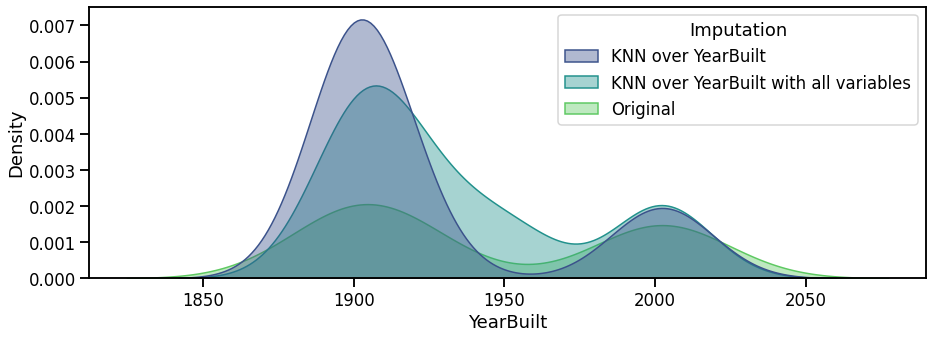

In [25]:
# Imputación de YearBuilt
mice_year_built = melb_data_mice.YearBuilt.to_frame()
mice_year_built['Imputation'] = 'KNN over YearBuilt'
mice_year_built_all = melb_data_stt.YearBuilt.to_frame() 
mice_year_built_all['Imputation'] = 'KNN over YearBuilt with all variables'
melb_year_build = melb_df_aux.YearBuilt.dropna().to_frame()
melb_year_build['Imputation'] = 'Original'
data = pd.concat([mice_year_built, mice_year_built_all, melb_year_build], ignore_index=True)
fig = plt.figure(figsize=(15, 5))
g = sns.kdeplot(data=data, x='YearBuilt', hue='Imputation', palette="viridis", fill = True, alpha = 0.4)

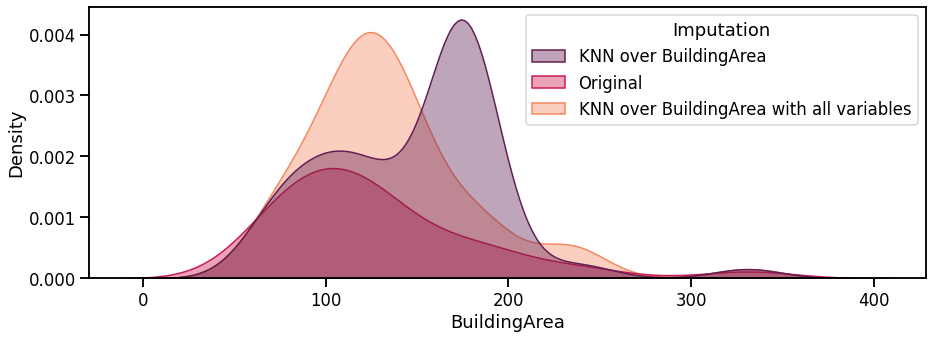

In [26]:
#BuildingArea
mice_built_area = melb_data_mice.BuildingArea.to_frame()
mice_built_area['Imputation'] = 'KNN over BuildingArea'
mice_built_all = melb_data_stt.BuildingArea.to_frame()
mice_built_all['Imputation'] = 'KNN over BuildingArea with all variables'
melb_build_area = melb_df_aux.BuildingArea.dropna().to_frame()
melb_build_area['Imputation'] = 'Original'
data2 = pd.concat([mice_built_area, melb_build_area, mice_built_all], ignore_index= True)
fig = plt.figure(figsize=(15, 5))
g = sns.kdeplot(data=data2, x='BuildingArea', hue='Imputation', fill=True, palette="rocket", alpha = 0.4)
sns.color_palette("rocket", as_cmap=True)

La imputación de los datos mejora considerablemente cuando se tienen en cuenta todas las variables numéricas, la distribución de la variable se asemeja un poco más a la original, no obstante sigue sin ser la mejor imputación dado que lo óptimo sean iguales o que sean lo más similares posible. 

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

#### 1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?

Para asegurar de que todas las variables estén en las mismas unidades y ninguna tenga un peso demasiado grande, sera necesario estandarizar o escalar los datos para aplicar PCA.

In [27]:
#Aplicacion PCA en base al ejemplo de clase
from sklearn.preprocessing import MinMaxScaler
matrix_imp = melb_data_s #Tomo la matriz con los datos imputados y sin estandarizar
scaler = MinMaxScaler() # Esta vez vamos a escalar los datos en vez de estandarizar para que sea más claro en el gráfico de la varianza la cantidad de 
#componentes principales a elegir 
scaled_matrix = scaler.fit_transform(matrix_imp)
np.max(scaled_matrix), np.min(scaled_matrix)

(1.0000000000000002, 0.0)

In [28]:
from sklearn.decomposition import PCA
n = min(20, matrix_imp.shape[0])

pca = PCA(n_components=n)

principalComponents = pca.fit_transform(scaled_matrix)

melb_data_stt[['Principal Component 1', 'Principal Component 2']] = principalComponents[:,:2] #Tomamos el dataframe de la matriz a la cual se le aplicó PCA

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


## 2- Grafico de la varianza capturada por los primeros $n$ componentes principales, para cada $n$.

In [29]:
print("Explained variance: ")
print(pca.explained_variance_)
print("Explained variance ratio")
print(pca.explained_variance_ratio_)

Explained variance: 
[0.54653286 0.43588524 0.31422495 0.20467596 0.20034235 0.1515004
 0.13315251 0.09766888 0.08544804 0.07440029 0.05021477 0.04471075
 0.02728099 0.02240628 0.01690578 0.01256488 0.01053796 0.00848296
 0.00701046 0.00633997]
Explained variance ratio
[0.22201852 0.17707004 0.12764787 0.08314569 0.08138525 0.06154414
 0.05409066 0.03967611 0.03471163 0.0302237  0.02039879 0.01816289
 0.01108238 0.00910212 0.00686765 0.00510424 0.00428085 0.00344604
 0.00284786 0.00257549]


/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:514: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot([], [], **kws)
/usr/local/lib/python3.7/dist-packages/seaborn/relational.py:529: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  line, = ax.plot(x, y, **kws)
No handles with labels found to put in legend.


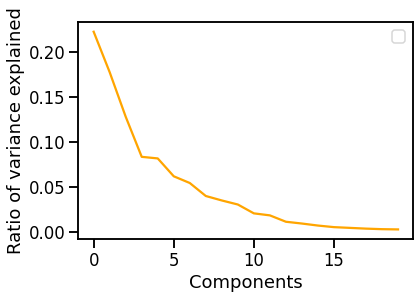

In [30]:
sns.lineplot(x=range(pca.n_components),
                 y=pca.explained_variance_ratio_,c = 'orange')
plt.ylabel("Ratio of variance explained")
plt.xlabel("Components")
plt.legend()

In [31]:
A = pca.explained_variance_ratio_[0]
B = pca.explained_variance_ratio_[1]
C = pca.explained_variance_ratio_[2]
D = A+B+C

print("1:{}\n2:{}\n3:{}\nsum:{}".format(A, B, C, D))

#  El Principal Component 1 contiene A % de la varianza y el Segundo Principal Component contiene B % de la varianza.
# La suma de los tres primeros componentes posee aproximadamente el 52% de la informacion.

1:0.22201851703453557
2:0.17707003967511797
3:0.1276478749459084
sum:0.5267364316555619


### Gráfico PCA

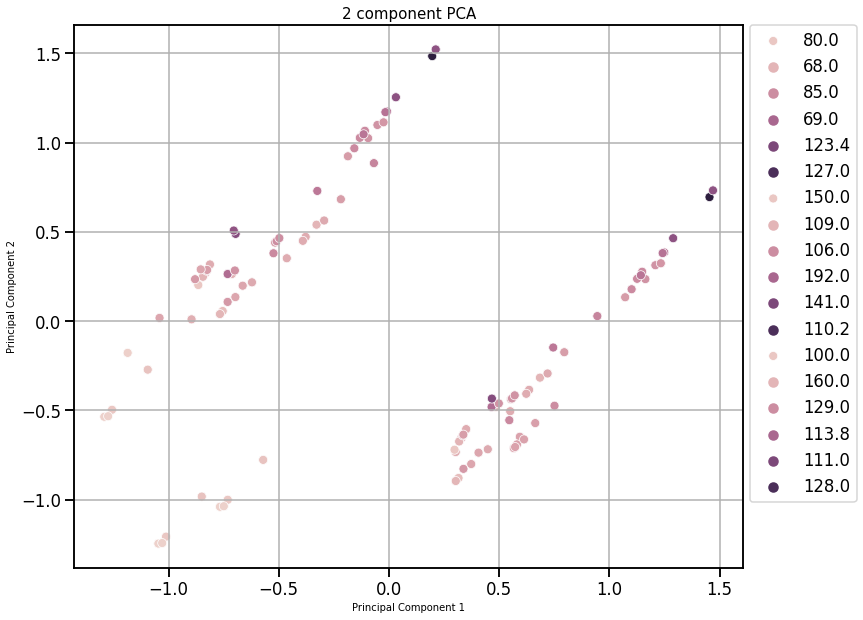

In [32]:
fig = plt.figure(figsize = (12,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 10)
ax.set_ylabel('Principal Component 2', fontsize = 10)
ax.set_title('2 component PCA', fontsize = 15)
targets = list(melb_data_stt['BuildingArea'].unique())
sample = ['1', '2', '3']

for target, s in zip(targets,sample):
    indicesToKeep = melb_data_stt['BuildingArea'] == target
    sns.scatterplot(data=melb_data_stt, x='Principal Component 1', y='Principal Component 2',hue='BuildingArea')

ax.legend(targets, bbox_to_anchor=(1.01, 1.0), loc='upper left', borderaxespad=0)
ax.grid()

## 3- En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

In [33]:
# Vamos a elegir las primeras 3 columnas de la matriz transformada como nuevas características al conjunto de datos
_pca = principalComponents[:,:2] #Esto nos devuelve un array 

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

In [34]:
## Small example
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

## If we process our data with the following steps:
numerical_cols = ['BuildingArea', 'YearBuilt', 'Landsize','Rooms','Price','Distance','Postcode','Bedroom2','Bathroom','Car','Lattitude','Longtitude','Rent Price mean','Rent Price min', 'Rent Price count', 'Review Scores Rating median']
categorical_cols = ['Suburb','Property Type']
new_columns = []

# Step 1: encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = encoder.fit_transform(melb_df_2[categorical_cols])
for col, col_values in zip(categorical_cols, encoder.categories_):
  for col_value in col_values:
    new_columns.append('{}={}'.format(col, col_value))
print("Matrix has shape {}, with columns: {}".format(X_cat.shape, new_columns))

# Step 2: Append the numerical columns
X = np.hstack([X_cat, melb_data_stt[numerical_cols].values])
new_columns.extend(numerical_cols)
print("Matrix has shape {}, with columns: {}".format(X.shape, new_columns))

# Step 3: Append some new features, like PCA
pca = PCA(n_components=3)
pca_dummy_features = pca.fit_transform(X)
X_pca = np.hstack([X, pca_dummy_features])
new_columns.extend(['PrinciaplComponent1', 'PrincipalComponent2', 'PrincipalComponent3'])
print("Matrix has shape {}, with columns: {}".format(X_pca.shape, new_columns))


## Re-build dataframe
processed_melb_df = pd.DataFrame(data= X_pca, columns = new_columns)
processed_melb_df.head()

Matrix has shape (110, 13), with columns: ['Suburb=Brunswick', 'Suburb=Carlton', 'Suburb=Fitzroy North', 'Suburb=Melbourne', 'Suburb=Northcote', 'Suburb=Port Melbourne', 'Suburb=Prahran', 'Suburb=Richmond', 'Suburb=Seddon', 'Property Type=Apartment', 'Property Type=Condominium', 'Property Type=House', 'Property Type=Serviced apartment']
Matrix has shape (110, 29), with columns: ['Suburb=Brunswick', 'Suburb=Carlton', 'Suburb=Fitzroy North', 'Suburb=Melbourne', 'Suburb=Northcote', 'Suburb=Port Melbourne', 'Suburb=Prahran', 'Suburb=Richmond', 'Suburb=Seddon', 'Property Type=Apartment', 'Property Type=Condominium', 'Property Type=House', 'Property Type=Serviced apartment', 'BuildingArea', 'YearBuilt', 'Landsize', 'Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Lattitude', 'Longtitude', 'Rent Price mean', 'Rent Price min', 'Rent Price count', 'Review Scores Rating median']
Matrix has shape (110, 32), with columns: ['Suburb=Brunswick', 'Suburb=Carlton', 'Suburb=Fitz

,Suburb=Brunswick,Suburb=Carlton,Suburb=Fitzroy North,Suburb=Melbourne,Suburb=Northcote,Suburb=Port Melbourne,Suburb=Prahran,Suburb=Richmond,Suburb=Seddon,Property Type=Apartment,...,Car,Lattitude,Longtitude,Rent Price mean,Rent Price min,Rent Price count,Review Scores Rating median,PrinciaplComponent1,PrincipalComponent2,PrincipalComponent3
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,-37.8106,144.9646,145.948112,19.0,3045.0,95.0,-9.166508e+05,2462.191049,1668.089953
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,-37.8072,144.9623,145.948112,19.0,3045.0,95.0,-8.796512e+05,4201.904098,759.287905
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,-37.8095,144.9691,145.948112,19.0,3045.0,95.0,-6.396506e+05,1651.708377,2147.738111
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,-37.8211,144.9559,145.948112,19.0,3045.0,95.0,-1.039651e+06,1581.157536,2108.550483
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-37.8106,144.9646,134.444444,25.0,108.0,96.0,-9.166503e+05,1086.676154,-926.566022


In [35]:
processed_melb_df.to_csv("melb_df_transformado.csv", index=None) #Este código guarda el dataframe en un archivo csv

In [36]:
from google.colab import files
files.download('melb_df_transformado.csv') #Este código es para descargar el archivo csv a la computadora

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más 
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de 
     publicaciones de la plataforma AirBnB en el mismo código 
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el 
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```
